In [9]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.activations import softmax, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, PReLU, LeakyReLU, Input, BatchNormalization, Activation


In [67]:
# 출력 전부 보이기
# np.set_printoptions(threshold=sys.maxsize)

In [3]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
with open('../colume_pickle/test_complete_df_6개월_choice_10개_대형주.pkl', 'rb') as f:
    stock_df = pickle.load(f)
with open('../colume_pickle/6개월_choice_10개_cor_0.065_lstm_대형주.pkl', 'rb') as f:
    col_list = pickle.load(f)

In [70]:
# col_list = col_list.drop('날짜')

In [7]:
col_list

시간            -0.306454
시가            -0.067072
고가            -0.066999
저가            -0.067114
종가            -0.067027
                 ...   
코스피50내역_변동     0.101550
코스피지수내역_변동     0.100598
헝가리BUX내역_오픈   -0.080854
헝가리BUX내역_고가   -0.067347
헝가리BUX내역_저가   -0.067341
Name: pct_label, Length: 67, dtype: float64

In [10]:
# 원 핫 기준 fit
cate = pd.DataFrame({'pct_label' : [0,1]})
ohe = OneHotEncoder(sparse=False)
ohe_test = ohe.fit_transform(cate[['pct_label']])
len(ohe_test[0])

2

In [11]:
stock_df['pct_label'].value_counts()

0.0     103626
0.2      52866
0.3      39303
0.1      38075
0.5      35965
         ...  
20.1         1
19.5         1
20.8         1
15.9         1
21.9         1
Name: pct_label, Length: 191, dtype: int64

In [12]:
stock_df['pct_label'] = np.where(stock_df['pct_label'].values > 0.5 , 1, 0)
stock_df['pct_label'].value_counts()

0    305414
1    220366
Name: pct_label, dtype: int64

In [13]:
y_stock_df = ohe.transform(stock_df[['pct_label']])
y_stock_df.shape

(525780, 2)

In [14]:
col_list = list(col_list.index)
X_stock_df = stock_df.drop(['pct_label'],axis=1)
X_stock_df = X_stock_df.set_index(['날짜'])
X_stock_df = X_stock_df[col_list]
X_stock_df.shape[1]

67

In [19]:
print(list(X_stock_df.isnull().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
min_abs_scaler = MaxAbsScaler()
X_stock_sc = min_abs_scaler.fit_transform(X_stock_df)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_stock_sc, y_stock_df, test_size=0.3,shuffle=True, random_state=42,stratify=y_stock_df)

In [91]:
X_train = X_train.reshape(X_train.shape[0], X_stock_df.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_stock_df.shape[1], 1)
print('훈련 데이터의 크기 :', X_train.shape, y_train.shape)
print('테스트 데이터의 크기 :', X_test.shape, y_test.shape)

훈련 데이터의 크기 : (368046, 49, 1) (368046, 2)
테스트 데이터의 크기 : (157734, 49, 1) (157734, 2)


In [92]:
inputs = Input(shape=(X_stock_df.shape[1],1))
lstm_out = LSTM(16, dropout=0.2,return_sequences=True)(inputs)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('PReLU')(lstm_out)
lstm_out = LSTM(16, dropout=0.2)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('PReLU')(lstm_out)
lstm_out = Dense(2)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('softmax')(lstm_out) 

# stop지점 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 이름 설정   모델_ep_bs_pa_lr_cor
modelpath="./model/lstm_30_64_5_0.001_0.07_대형주_범위(0,1).hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model = Model(inputs=inputs, outputs=lstm_out)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001, decay=1e-7), metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=30, batch_size=64,verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping_callback, checkpointer])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 49, 16)            1152      
                                                                 
 batch_normalization (BatchN  (None, 49, 16)           64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 49, 16)            784       
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                             

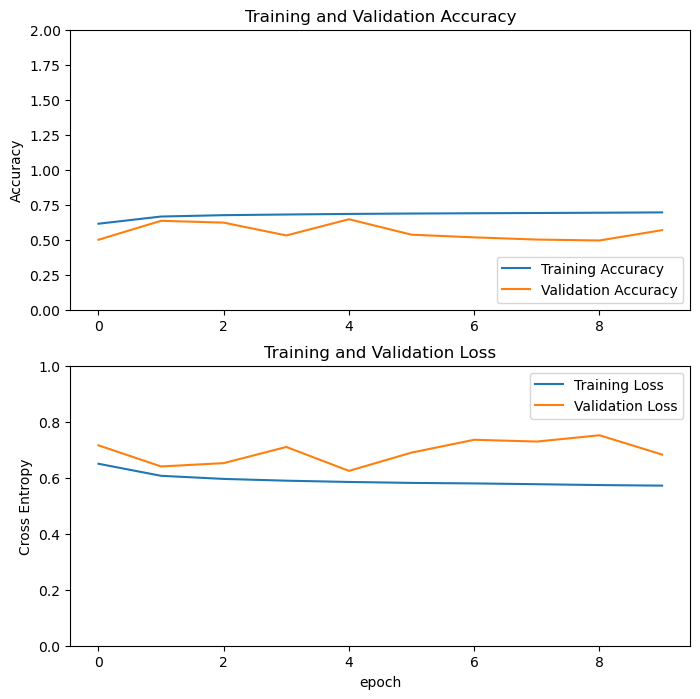

In [93]:
# #Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [98]:
modelpath="./model/lstm_30_64_5_0.001_0.07_대형주_범위(0,1).hdf5"
model_pred = load_model(modelpath)

In [99]:
predict = model_pred.predict(X_test)
pred_X = tf.argmax(predict,1).numpy()
np.unique(pred_X,return_counts=True)

4930/4930 [==============================] - 21s 4ms/step


(array([0, 1], dtype=int64), array([81965, 75769], dtype=int64))

In [ ]:
print("\n Test Accuracy: %.4f" % (model_pred.evaluate(X_test, y_test)[1]))

In [ ]:
with open('../colume_pickle/6개월_choice_10개_대형주_update_000660.pkl', 'rb') as f:
    pred_df = pickle.load(f)

In [ ]:
pred_df['pct_label'] = np.where(pred_df['pct_label'].values > 0.5 , 1, 0)
# pred_df['pct_label'] = np.where(pred_df['pct_label'].values > 4 , 5, pred_df['pct_label'].values)

In [ ]:
pred_df['pct_label'].value_counts()

0    298
1     83
Name: pct_label, dtype: int64

In [ ]:
y_pred_df = ohe.transform(pred_df[['pct_label']])
y_pred_df.shape

(381, 2)

In [ ]:
# col_list = list(col_list.index)
X_pred_df = pred_df.drop(['pct_label'],axis=1)
X_pred_df = X_pred_df.set_index(['날짜'])
X_pred_df = X_pred_df[col_list]
X_pred_sc = min_max_scaler.fit_transform(X_pred_df)
X_pred = X_pred_sc.reshape(X_pred_sc.shape[0], 37, 1)


In [ ]:
predict_ = model_pred.predict(X_pred)

12/12 [==============================] - 0s 9ms/step


In [ ]:
predict_

array([[0.79837674, 0.20162326],
       [0.7984612 , 0.20153883],
       [0.7989549 , 0.20104511],
       [0.7991271 , 0.20087294],
       [0.7999861 , 0.20001394],
       [0.80030376, 0.19969623],
       [0.80035293, 0.19964707],
       [0.8006052 , 0.19939484],
       [0.8007049 , 0.1992951 ],
       [0.8005401 , 0.19945993],
       [0.8007222 , 0.19927783],
       [0.80111665, 0.1988833 ],
       [0.8025658 , 0.19743423],
       [0.8026955 , 0.19730444],
       [0.8024508 , 0.1975492 ],
       [0.80265725, 0.19734275],
       [0.80289197, 0.19710806],
       [0.80338675, 0.19661324],
       [0.8032693 , 0.19673072],
       [0.8035693 , 0.19643068],
       [0.8036688 , 0.19633119],
       [0.8037801 , 0.1962199 ],
       [0.80418444, 0.1958156 ],
       [0.8042375 , 0.1957625 ],
       [0.80444926, 0.19555072],
       [0.8043554 , 0.19564457],
       [0.80440825, 0.19559175],
       [0.8044768 , 0.1955232 ],
       [0.8047741 , 0.19522591],
       [0.8047278 , 0.1952722 ],
       [0.

In [ ]:
pred = tf.argmax(predict_,1).numpy()
np.unique(pred,return_counts=True)

(array([0], dtype=int64), array([381], dtype=int64))

In [ ]:
cost = 10000000 # 잔고
for x in tqdm(range(len(predict_))):
    
    end_cost = pred_df.loc[x,'종가']   # 종가
    high_cost = pred_df.loc[x,'고가']   # 고가
    
    stock_cost = 1000000    # 종목별 매수 금액
    num = 0 # 가지고 있는 주
    # num = 매수금액 / 종가
    # print(predict_[x][0] < predict_[x][1])
    print(predict_[x][0] < predict_[x][1])
    if pred[x] == 1 and end_cost < high_cost and stock_cost > end_cost*buy_num:
        buy_num = stock_cost / end_cost
        stock_cost = stock_cost - (end_cost*buy_num) # 매수
        num += buy_num
    elif pred[x] == 0 :
        stock_cost = stock_cost + (high_cost * num) # 매도
        num -= num
    # else:
    #     hold
    print(stock_cost)
cost = cost + (stock_cost - 1000000)

100%|██████████| 381/381 [00:00<00:00, 41879.29it/s]

False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
1000000.0
False
10

In [ ]:
cost

10000000.0

In [ ]:
pred = tf.argmax(predict_,1).numpy()
test = tf.argmax(y_pred_df,1).numpy()

In [ ]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
np.unique(pred,return_counts=True)

(array([0], dtype=int64), array([381], dtype=int64))

In [ ]:
np.unique(test,return_counts=True)

(array([0, 1], dtype=int64), array([329,  52], dtype=int64))

In [ ]:
acc = accuracy_score(test, pred)
print('accuracy_score : ',acc)

accuracy_score :  1.0


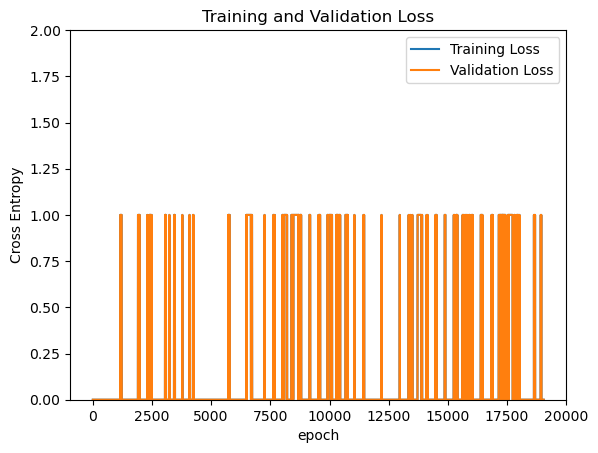

In [ ]:

plt.plot(test, label='Training Loss')
plt.plot(pred, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()